In [1]:
#import libraries
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



In this project, we will use the Kaggle dataset and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease in the future.

In [2]:
df = pd.read_csv("heart_disease_prediction.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
print(df.dtypes)

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


The dataset has the following features:

Age: age of the patient [years]
Sex: sex of the patient [M: Male, F: Female]
ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
RestingBP: resting blood pressure [mm Hg]
Cholesterol: serum cholesterol [mm/dl]
FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
Oldpeak: oldpeak = ST [Numeric value measured in depression]
ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
HeartDisease: output class [1: heart disease, 0: Normal]

In [4]:
df.dtypes.value_counts()

int64      6
object     5
float64    1
Name: count, dtype: int64

7 features are numerical while 5 are categorical, however FastingBS and HeartDisease are categorical

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the table above, we can observe that:

The average age of patients is ~53 years.
The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
RestingBP and Cholesterol have a minimum value of zero.
There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.
RestingBP can't be 0. And, as per the American Heart Association, serum cholesterol is a composite of different measurements. So, it is unlikely that Cholesterol would be 0 as well. We will have to clean both of these up later.

Next, we will look at the categorical variables. It would also be beneficial to look at how the target feature, HeartDisease, is related to those categories. Before that, let's quickly check if there are any missing values in the dataset or not.

In [6]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

EDA: Categorical Data: Let's see

In [7]:
df.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [9]:
df['FastingBS'].unique(),df['HeartDisease'].unique() #Also categorical data, 1 and 0

(array([0, 1]), array([0, 1]))

Let's look at the categories in more detail

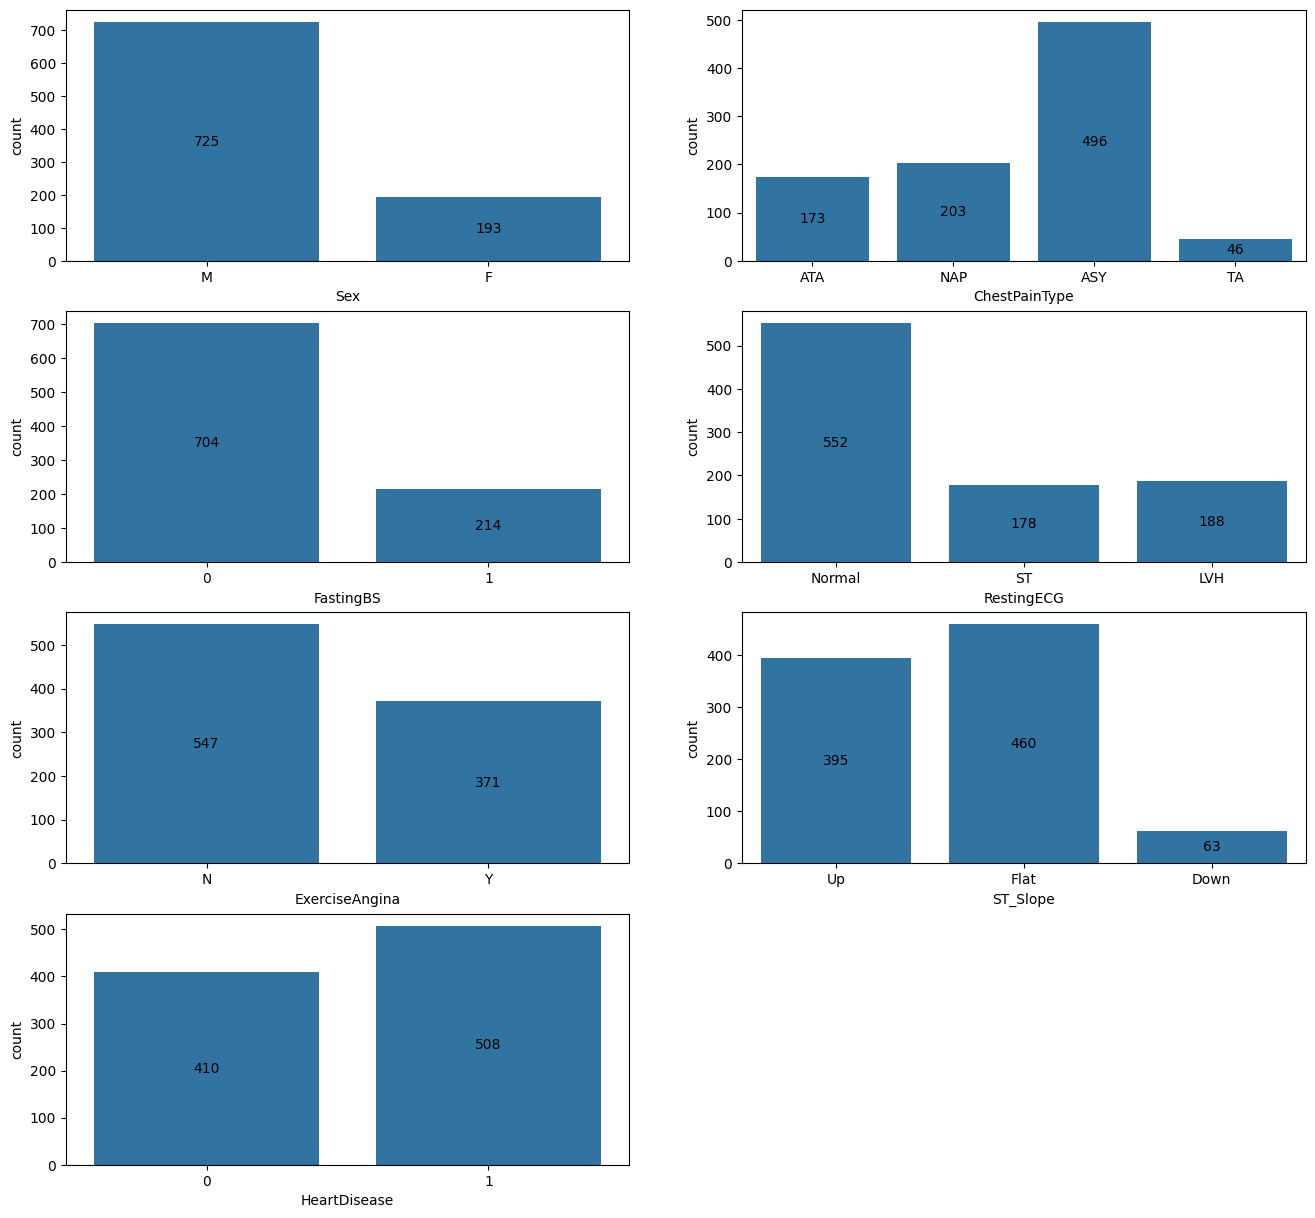

In [14]:
categorical_cols = ["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","ST_Slope","HeartDisease"]

fig = plt.figure(figsize = (16,15))

for idx,col in enumerate (categorical_cols):
    ax = plt.subplot(4,2,idx+1)
    sns.countplot(x=df[col],ax=ax)
    #Add labels for each bar
    for container in ax.containers :
        ax.bar_label(container,label_type = 'center')

There is a skew toward male patients. Now let's group by heart disease

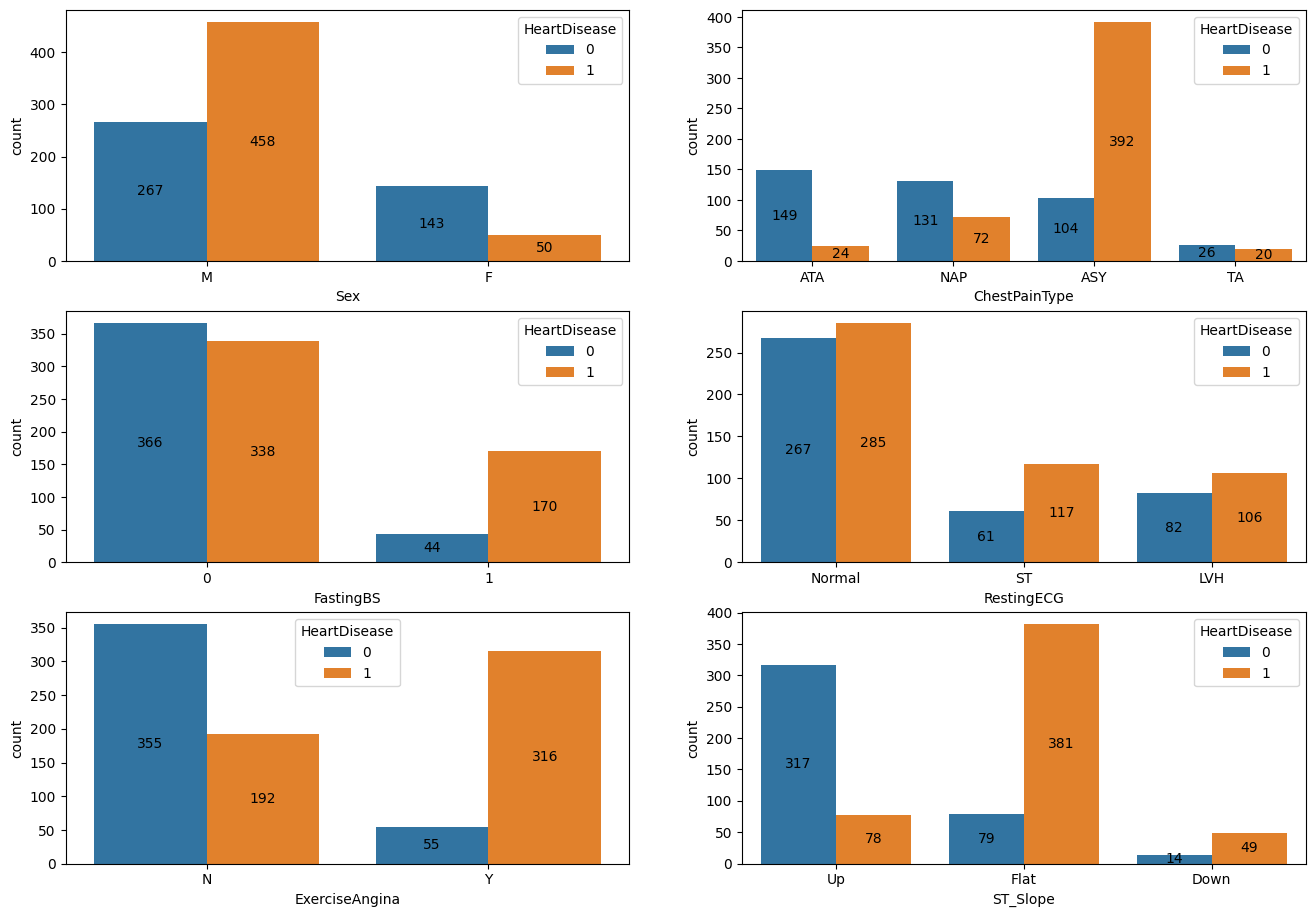

In [15]:
fig = plt.figure(figsize = (16,15))
for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4,2,idx+1)
    #Group by heart disease
    sns.countplot(x=df[col],hue=df["HeartDisease"],ax=ax)
    #Add data labels for each bar
    for container in ax.containers:
        ax.bar_label(container,label_type = "center")

We can further notice how skewed the dataset is towards male patients. Only 50 female patients in the dataset have been diagnosed with heart disease.
A significant number of patients, 392, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
A high number (170) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
Out of all patients who had an exercise-induced angina, 316 were diagnosed with a heart disease.
Out of all patients with a flat ST slope, 381 were diagnosed with a heart disease.

Data Cleaning: Let's look at zero values that do not make sense, mainly in RestingBP and Cholesterol

In [16]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [17]:
df[df["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


RestingBP has only one zero value. We can remove that row from consideration. There are 172 zero values for Cholesterol. That's a relatively high number. We can't remove them all and replacing those values with the median might not be an ideal approach, but that's what we will go for now.

To be more accurate, we will replace the zero values in Cholesterol in relation to HeartDisease. So, the 0 values in Cholesterol for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [19]:
df_clean = df.copy()

#Only keep non-zero values for restingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]
heartdisease_mask = df_clean["HeartDisease"] == 0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask,"Cholesterol"]

df_clean.loc[heartdisease_mask,"Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0,value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask,"Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0,value = cholesterol_with_heartdisease.median())

In [20]:
df_clean[["Cholesterol","RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


Feature Selection: We can start with the following features: Age, Sex, ChestPainType,Cholesterol,FastingBS. For this we must first convert our features into variable dummies

In [21]:
df_clean = pd.get_dummies(df_clean,drop_first = True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


Is there a correlation between them?

<Axes: >

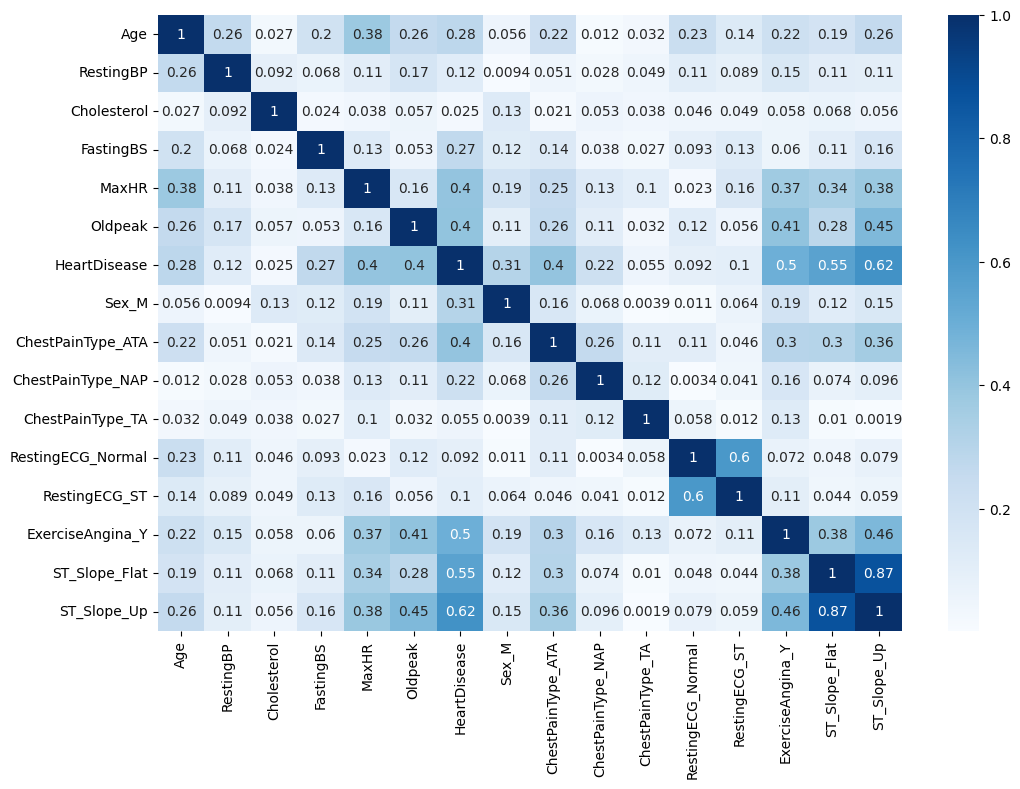

In [23]:
correlation = abs(df_clean.corr())
plt.figure(figsize = (12,8))
sns.heatmap(correlation,annot = True, cmap = "Blues")

<Axes: >

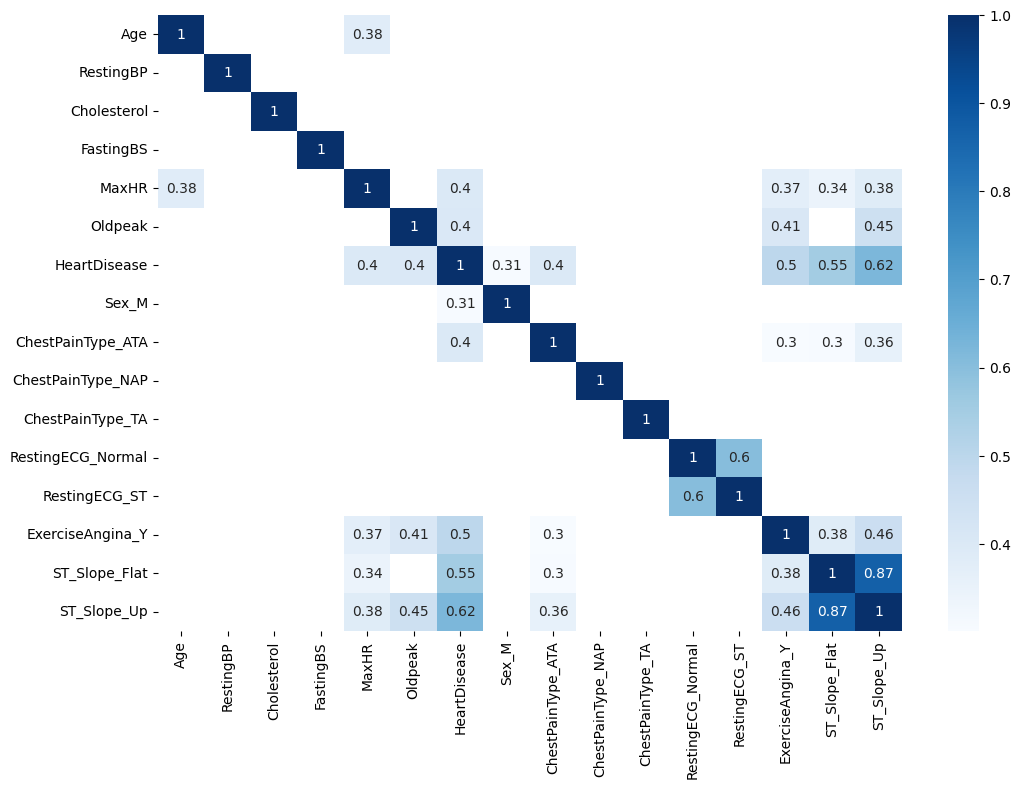

In [26]:
plt.figure(figsize = (12,8))
sns.heatmap(correlation[correlation > 0.3],annot = True, cmap = "Blues")

From the heatmap, we can see positive correlation between HeartDisease and: Oldpeak,MaxHR,Chestpaintype_ATA,ExcerciseAngina_Y,ST_Slope_Flat and ST_Slope_Up. Wierdly enough, Cholesterol doesn't correlate heavily. Given this we can narrow the features as:
Oldpeak,Sex_M,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up

Building the classifier with one feature: First let's split the data set for training and test

In [27]:
X = df_clean.drop(["HeartDisease"],axis = 1)
y = df_clean["HeartDisease"]

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.15, random_state = 417)

features = ["Oldpeak","Sex_M","ExerciseAngina_Y","ST_Slope_Flat","ST_Slope_Up"]


Let's create a model for each feature and evaluate them by their accuracy

In [29]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]],y_train)
    accuracy = knn.score(X_val[[feature]],y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 76.81%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 44.93%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 84.06%


Now let's prepare the data for Hyperparameter optimization

In [35]:
X = df_clean.drop(["HeartDisease"],axis = 1)
y = df_clean["HeartDisease"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,random_state = 417)





scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

Let's use grid search to explore the range of values for k and distance metrics:
k in range (1,20)
distance metrics minkowski and manhattan

In [32]:
grid_params = {"n_neighbors":range(1,20),"metric":["minkowski","manhattan"]
}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn,grid_params,scoring = "accuracy")
knn_grid.fit(X_train_scaled,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [33]:
knn_grid.best_score_*100, knn_grid.best_params_

(np.float64(83.56327543424318), {'metric': 'minkowski', 'n_neighbors': 19})

Now lest evaluate the model on test set

In [36]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test,predictions)
print(f"Model Accuracy on test set: {accuracy*100:.2f}%")

Model Accuracy on test set: 86.23%


The model accuracy for test is higher than the training which is odd, an explanation can be assesed based on how the data is distributed, let's see

In [40]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts(normalize = True))
print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts(normalize = True))
print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts(normalize = True))

Distribution of patients by their sex in the entire dataset
Sex_M
True     0.789531
False    0.210469
Name: proportion, dtype: float64

Distribution of patients by their sex in the training dataset
Sex_M
True     0.789474
False    0.210526
Name: proportion, dtype: float64

Distribution of patients by their sex in the test dataset
Sex_M
True     0.789855
False    0.210145
Name: proportion, dtype: float64


It is interesting that eventhough the distribution of the data remains the same, 